In [2]:
from google.colab import drive
import os
import sys
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Concatenate, Add, Dot, Multiply, Reshape, Activation, BatchNormalization, SimpleRNNCell, RNN, SimpleRNN, LSTM, Embedding, Bidirectional, TimeDistributed, Conv1D, Conv2D, MaxPool1D, MaxPool2D, GlobalMaxPool1D, GlobalMaxPool2D, AveragePooling1D, AveragePooling2D, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import Input, Model, Sequential
from sklearn.model_selection import train_test_split

drive.mount("/content/drive", force_remount=True)
try:
    my_path = "/content/notebooks"
    os.symlink("/content/drive/MyDrive/ColabNotebooks/my_env", my_path)
    sys.path.insert(0, my_path)
except:
    pass
os.chdir(my_path)

def set_css():
  display(HTML("""
  <style>
    pre {white-space: pre-wrap;}
  </style>
  """))
get_ipython().events.register("pre_run_cell", set_css)

plt.style.use("dark_background")

Mounted at /content/drive


In [3]:
(x_tr, y_tr), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
y_tr = tf.keras.utils.to_categorical(y_tr)
y_test = tf.keras.utils.to_categorical(y_test)
x_tr, x_val, y_tr, y_val = train_test_split(x_tr, y_tr, train_size=0.8, shuffle=True, random_state=777)

gen_tr = ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
gen_val = ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)

In [6]:
def inception(x, filters): 
    f1, f2, f3, f4 = filters

    # 1x1
    conv1 = Conv2D(filters=f1, kernel_size=1, padding="same", activation="relu")(x)
    # 1x1 & 3x3
    conv2 = Conv2D(filters=f4, kernel_size=1, padding="same", activation="relu")(x)
    conv2 = Conv2D(filters=f2, kernel_size=3, padding="same", activation="relu")(conv2)
    # 1x1 & 5x5
    conv3 = Conv2D(filters=f4, kernel_size=1, padding="same", activation="relu")(x)
    conv3 = Conv2D(filters=f3, kernel_size=5, padding="same", activation="relu")(conv3)
    # pooling & 1x1
    max_pool = MaxPool2D(pool_size=3, strides=1, padding="same")(x)
    max_pool = Conv2D(filters=f4, kernel_size=1, padding="same", activation="relu")(max_pool)

    concat = Concatenate(axis=-1)([conv1, conv2, conv3, max_pool])

    def se_block(x, c, r):
        z = GlobalAveragePooling2D()(x)
        z = Dense(units=c//r, activation="relu")(z)
        z = Dense(units=c, activation="sigmoid")(z)
        z = Reshape(target_shape=(1, 1, c))(z)
        z = Multiply()([x, z])
        return z
    
    z = se_block(concat, c=f1+f2+f3+f4, r=16)
    return z

input_shape = x_tr[0].shape
inputs = Input(shape=input_shape)

# conv랑 batch 사이에 max pooling 들어가야 하나, cifar 데이터에선 크기 너무 줄어들어서 뺐음
z = Conv2D(filters=64, kernel_size=7, strides=2, padding="same", activation="relu")(inputs)
# z = MaxPool2D(pool_size=3, strides=2, padding="same"(z)
z = BatchNormalization()(z)
z = Conv2D(filters=192, kernel_size=3, padding="same", activation="relu")(z)
# z = MaxPool2D(pool_size=3, strides=2, padding="same"(z)
z = BatchNormalization()(z) 
# inception 3a
z = inception(z, [64, 128, 32, 32])
# inception 3b
z = inception(z, [128, 192, 96, 64])
z = MaxPool2D(pool_size=3, strides=2, padding="same")(z)
# inception 4a
z = inception(z, [192, 208, 48, 64])
# Auxiliary Classifier
aux1 = AveragePooling2D(pool_size=5, strides=3, padding="valid")(z)
aux1 = Conv2D(filters=128, kernel_size=1, padding="same", activation="relu")(aux1)
aux1 = Flatten()(aux1)
aux1 = Dense(units=512, activation="relu")(aux1)
aux1 = Dense(units=10, activation="softmax")(aux1)
# inception 4b
z = inception(z, [160, 224, 64, 64])
# inception 4c
z = inception(z, [128, 256, 64, 64])
# inception 4d
z = inception(z, [112, 288, 64, 64])
# Auxiliary Classifier
aux2 = AveragePooling2D(pool_size=5, strides=3, padding="valid")(z)
aux2 = Conv2D(128, kernel_size=1, padding="same", activation="relu")(aux2)
aux2 = Flatten()(aux2)
aux2 = Dense(units=832, activation="relu")(aux2)
aux2 = Dense(units=10, activation="softmax")(aux2)
# inception 4e
z = inception(z, [256, 320, 128, 128])
z = MaxPool2D(pool_size=3, strides=2, padding="same")(z)
# inception 5a
z = inception(z, [256, 320, 128, 128])
# inception 5b
z = inception(z, [384, 384, 128, 128])
z = GlobalAveragePooling2D()(z)
z = Dropout(rate=0.4)(z)
z = Flatten()(z)

outputs = Dense(units=10, activation="softmax", name="outputs")(z)

model = Model(inputs=inputs, outputs=[aux1, aux2, outputs])

model.compile(optimizer="adam", loss="categorical_crossentropy", loss_weights=[0.3, 0.3, 1],
              metrics=["acc"]) 

model.summary()

es = EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=2)
model_path = "SE-GoogLeNet_cifar10.h5"
mc = ModelCheckpoint(filepath=model_path, monitor="val_outputs_acc", mode="auto", verbose=1,
                     save_best_only=True)

epochs = 20
hist = model.fit(x=gen_tr.flow(x_tr, y_tr, batch_size=32), validation_data=gen_val.flow(x_val, y_val, batch_size=32),
                 epochs=epochs, callbacks=[es, mc])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_116 (Conv2D)             (None, 16, 16, 64)   9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 16, 16, 64)   256         conv2d_116[0][0]                 
__________________________________________________________________________________________________
conv2d_117 (Conv2D)             (None, 16, 16, 192)  110784      batch_normalization_4[0][0]      
____________________________________________________________________________________________

Text(0.5, 1.0, 'Training and Validation Loss')

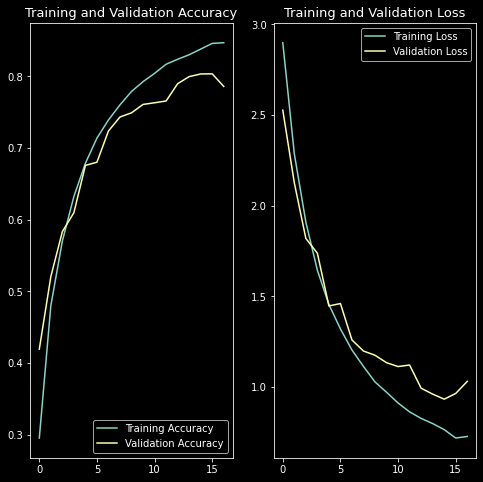

In [11]:
epochs = 17
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))

ax1.plot(range(epochs), hist.history["outputs_acc"], label="Training Accuracy")
ax1.plot(range(epochs), hist.history["val_outputs_acc"], label="Validation Accuracy")
ax1.legend(loc="lower right")
ax1.set_title("Training and Validation Accuracy", size=13)

ax2.plot(range(epochs), hist.history["loss"], label="Training Loss")
ax2.plot(range(epochs), hist.history["val_loss"], label="Validation Loss")
ax2.legend(loc="upper right")
ax2.set_title("Training and Validation Loss", size=13)